## 파일 목적  
실제 데이터(concrete 데이터셋)를 불러와 Surrogate Model에 gradient descent, GA를 구현하고 end-to-end로 문제없이 작동하는지 확인하기 위함

## 데이터 불러오기

In [2]:
import kagglehub

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
path = kagglehub.dataset_download("vinayakshanawad/cement-manufacturing-concrete-dataset")

In [4]:
print("Path to dataset files:", path)

Path to dataset files: /data/ephemeral/home/.cache/kagglehub/datasets/vinayakshanawad/cement-manufacturing-concrete-dataset/versions/1


In [5]:
path = "/data/ephemeral/home/.cache/kagglehub/datasets/vinayakshanawad/cement-manufacturing-concrete-dataset/versions/1"

In [6]:
import pandas as pd
df = pd.read_csv(path + "/concrete.csv")

df.head()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,141.3,212.0,0.0,203.5,0.0,971.8,748.5,28,29.89
1,168.9,42.2,124.3,158.3,10.8,1080.8,796.2,14,23.51
2,250.0,0.0,95.7,187.4,5.5,956.9,861.2,28,29.22
3,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85
4,154.8,183.4,0.0,193.3,9.1,1047.4,696.7,28,18.29


## 간단한 데이터 EDA

In [7]:
df.describe()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.167864,73.895825,54.188350,181.567282,6.204660,972.918932,773.580485,45.662136,35.817961
std,104.506364,86.279342,63.997004,21.354219,5.973841,77.753954,80.175980,63.169912,16.705742
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.710000
50%,272.900000,22.000000,0.000000,185.000000,6.400000,968.000000,779.500000,28.000000,34.445000
75%,350.000000,142.950000,118.300000,192.000000,10.200000,1029.400000,824.000000,56.000000,46.135000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


In [8]:
df.corr()


,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
cement,1.000000,-0.275216,-0.397467,-0.081587,0.092386,-0.109349,-0.222718,0.081946,0.497832
slag,-0.275216,1.000000,-0.323580,0.107252,0.043270,-0.283999,-0.281603,-0.044246,0.134829
ash,-0.397467,-0.323580,1.000000,-0.256984,0.377503,-0.009961,0.079108,-0.154371,-0.105755
water,-0.081587,0.107252,-0.256984,1.000000,-0.657533,-0.182294,-0.450661,0.277618,-0.289633
superplastic,0.092386,0.043270,0.377503,-0.657533,1.000000,-0.265999,0.222691,-0.192700,0.366079
coarseagg,-0.109349,-0.283999,-0.009961,-0.182294,-0.265999,1.000000,-0.178481,-0.003016,-0.164935
fineagg,-0.222718,-0.281603,0.079108,-0.450661,0.222691,-0.178481,1.000000,-0.156095,-0.167241
age,0.081946,-0.044246,-0.154371,0.277618,-0.192700,-0.003016,-0.156095,1.000000,0.328873
strength,0.497832,0.134829,-0.105755,-0.289633,0.366079,-0.164935,-0.167241,0.328873,1.000000


In [12]:

import torch
import sklearn

In [13]:
train,test = sklearn.model_selection.train_test_split(df, test_size=0.2, random_state=42)

In [14]:
train.shape

(824, 9)

In [15]:
test.shape

(206, 9)

In [16]:
train.describe()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
count,824.000000,824.000000,824.000000,824.000000,824.000000,824.000000,824.000000,824.000000,824.00000
mean,279.965413,75.690898,53.219539,181.983252,6.157160,972.918447,772.832039,45.701456,35.76557
std,104.609002,87.638248,63.987005,21.332896,5.949393,76.702670,80.330482,63.289443,16.65238
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.33000
25%,190.600000,0.000000,0.000000,164.900000,0.000000,932.000000,724.300000,14.000000,23.79750
50%,273.000000,23.000000,0.000000,185.700000,6.500000,968.000000,778.500000,28.000000,34.44500
75%,351.250000,145.000000,118.300000,193.000000,10.200000,1028.400000,824.000000,56.000000,45.91000
max,540.000000,359.400000,200.100000,246.900000,32.200000,1145.000000,992.600000,365.000000,80.20000


In [17]:
test.describe()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
count,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000
mean,285.977670,66.715534,58.063592,179.903398,6.394660,972.920874,776.574272,45.504854,36.027524
std,104.209555,80.416840,64.045839,21.410363,6.081593,82.018633,79.678916,62.842563,16.956835
min,116.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,3.000000,7.320000
25%,211.025000,0.000000,0.000000,163.250000,0.000000,931.400000,745.000000,7.000000,22.772500
50%,269.400000,20.000000,0.000000,182.100000,6.000000,967.000000,781.100000,28.000000,34.505000
75%,349.000000,129.800000,118.300000,192.000000,10.375000,1036.250000,825.375000,56.000000,47.340000
max,540.000000,359.400000,200.000000,247.000000,32.200000,1134.300000,992.600000,365.000000,82.600000


Q1: 0.0, Q3: 145.0, IQR: 145.0


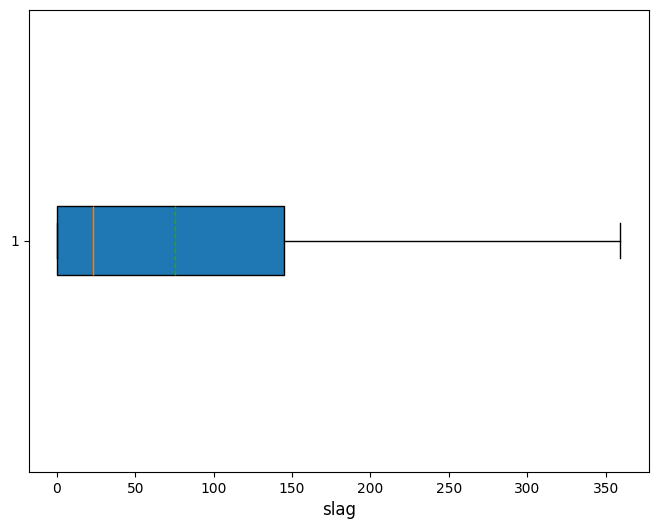

In [18]:
import numpy as np
import matplotlib.pyplot as plt

Q1 = train['slag'].quantile(0.25)
Q3 = train['slag'].quantile(0.75)
IQR = Q3 - Q1

print(f'Q1: {Q1}, Q3: {Q3}, IQR: {IQR}')

plt.figure(figsize=(8, 6))
plt.boxplot(train['slag'], vert=False, patch_artist=True, showmeans=True, meanline=True)
plt.xlabel('slag', fontsize=12)
plt.show()

Q1: 0.0, Q3: 129.8, IQR: 129.8


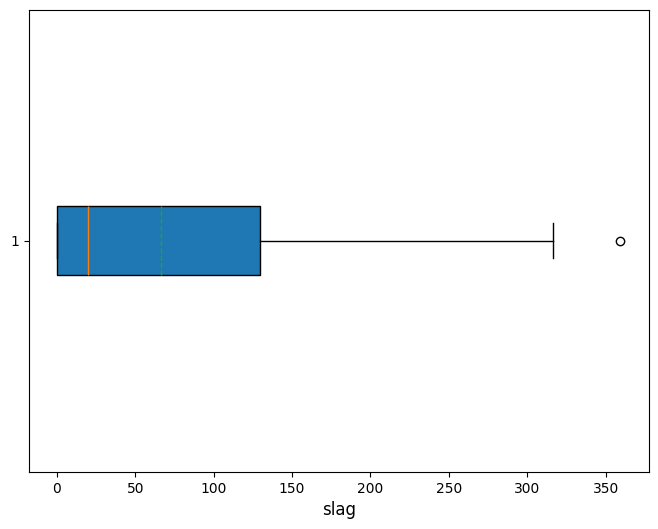

In [19]:
Q1 = test['slag'].quantile(0.25)
Q3 = test['slag'].quantile(0.75)
IQR = Q3 - Q1

print(f'Q1: {Q1}, Q3: {Q3}, IQR: {IQR}')

plt.figure(figsize=(8, 6))
plt.boxplot(test['slag'], vert=False, patch_artist=True, showmeans=True, meanline=True)
plt.xlabel('slag', fontsize=12)
plt.show()

## Search Model 학습 준비 및 학습

In [20]:
class ConcreteDataset(torch.utils.data.Dataset):
    def __init__(self, df, mean,std):
        self.df = df
        self.mean = mean
        self.std = std


    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        x = self.df.iloc[idx][['cement','slag','ash','water','superplastic','coarseagg','fineagg','age']].to_numpy()
        y = self.df.iloc[idx][['strength']].to_numpy()
        x = torch.tensor(x, dtype=torch.float32)    
        y = torch.tensor(y, dtype=torch.float32)
        x = (x - self.mean[:-1]) / self.std[:-1]
        # y = (y - self.mean[7]) / self.std[7]
        y = torch.log(y)
        # if self.transform:
        #     x = self.transform(x)
            
        return x, y

In [21]:
# dataset = ConcreteDataset(df)

# dataset[0]

In [52]:
train

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
995,380.0,0.0,0.0,228.0,0.0,932.0,670.0,365,52.52
507,251.8,0.0,99.9,146.1,12.4,1006.0,899.8,28,33.94
334,323.7,282.8,0.0,183.8,10.3,942.7,659.9,3,28.30
848,252.3,0.0,98.8,146.3,14.2,987.8,889.0,56,55.83
294,238.2,158.8,0.0,185.7,0.0,1040.6,734.3,28,26.91
...,...,...,...,...,...,...,...,...,...
87,212.5,0.0,100.4,159.3,8.7,1007.8,903.6,14,26.31
330,167.4,129.9,128.6,175.5,7.8,1006.3,746.6,14,31.81
466,439.0,177.0,0.0,186.0,11.1,884.9,707.9,3,39.30
121,250.0,0.0,95.7,191.8,5.3,948.9,857.2,56,39.64


In [79]:
mean = train[['cement','slag','ash','water','superplastic','coarseagg','fineagg','age','strength']].to_numpy().mean(axis=0)
std = train[['cement','slag','ash','water','superplastic','coarseagg','fineagg','age','strength']].to_numpy().std(axis=0)
mean = torch.tensor(mean, dtype=torch.float32)
std = torch.tensor(std, dtype=torch.float32)

In [80]:
print(mean)
print(std)

tensor([279.9654,  75.6909,  53.2195, 181.9832,   6.1572, 972.9185, 772.8320,
         45.7015,  35.7656])
tensor([104.5455,  87.5851,  63.9482,  21.3199,   5.9458,  76.6561,  80.2817,
         63.2510,  16.6423])


In [81]:
# import torchvision.transforms as transforms
# transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])
dataset_train = ConcreteDataset(train,mean,std)
dataset_test = ConcreteDataset(test,mean,std)

In [82]:
from torch.utils.data import DataLoader
train_loader = DataLoader(dataset_train, batch_size=100, shuffle=True)
test_loader = DataLoader(dataset_test, batch_size=100, shuffle=False)

In [94]:
class simple_nn(torch.nn.Module):
    def __init__(self):
        super(simple_nn, self).__init__()
        self.fc1 = torch.nn.Linear(8, 16)
        self.fc2 = torch.nn.Linear(16, 32)
        self.fc3 = torch.nn.Linear(32, 1)
    def forward(self, x):
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        x = torch.relu(x)
        xf = self.fc3(x)
        return xf,x

In [95]:
model = simple_nn()
model.cuda()

simple_nn(
  (fc1): Linear(in_features=8, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)

In [96]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [97]:
import numpy as np
losses = []
val_losses = []
errors = []
for i in range(200):
    Lo = []
    for inputs, outputs in train_loader:
        inputs = inputs.cuda()
        outputs = outputs.cuda()
        model.zero_grad()
        pred,_ = model(inputs)
        loss = torch.nn.MSELoss()(pred, outputs)
        
        loss.backward()
        optimizer.step()
        Lo.append(loss.item())
    
    losses.append(np.mean(Lo))
    err = []
    vLo = []
    for inputs, outputs in test_loader:
        inputs = inputs.cuda()
        outputs = outputs.cuda()
        pred,_ = model(inputs)
        loss = torch.nn.MSELoss()(pred, outputs)
        vLo.append(loss.item())
        err.append(abs(torch.exp(pred.detach().cpu())- torch.exp(outputs.detach().cpu())).numpy())
    errors.append(np.concatenate(err,axis=0).mean())
    val_losses.append(np.mean(vLo))
    print(f'losses: {np.mean(losses)}')
    print(f'val_losses: {np.mean(val_losses)}')
    print(f'errors: {np.concatenate(err,axis=0).mean()}')

losses: 9.975184546576607
val_losses: 10.646121978759766
errors: 34.53104019165039
losses: 9.65825054380629
val_losses: 10.213988622029621
errors: 34.283912658691406
losses: 9.249255515910962
val_losses: 9.741136127048067
errors: 33.91594314575195
losses: 8.782293412420486
val_losses: 9.223886768023172
errors: 33.328208923339844
losses: 8.272678958045113
val_losses: 8.66085147857666
errors: 32.30321502685547
losses: 7.743645765163282
val_losses: 8.060308906767103
errors: 30.407032012939453
losses: 7.192019432310075
val_losses: 7.441611573809669
errors: 27.9564151763916
losses: 6.6403557625081815
val_losses: 6.835797409216562
errors: 27.270381927490234
losses: 6.1303460465537185
val_losses: 6.274568707854659
errors: 28.21320152282715
losses: 5.666123909420438
val_losses: 5.783417654037476
errors: 30.52383041381836
losses: 5.253682871659598
val_losses: 5.370164174022097
errors: 32.43618392944336
losses: 4.9010017260357195
val_losses: 5.024634185764525
errors: 32.627838134765625
losses: 4

In [98]:
len(val_losses)

200

In [99]:
mean

tensor([279.9654,  75.6909,  53.2195, 181.9832,   6.1572, 972.9185, 772.8320,
         45.7015,  35.7656])

In [100]:

err = []
mean_err = []
pred_y = []

for inputs, outputs in test_loader:
    inputs = inputs.cuda()
    outputs = outputs.cuda()
    pred,_ = model(inputs)
    loss = torch.nn.MSELoss()(pred, outputs)
    val_losses.append(loss.item())
    pred_y.append(torch.exp(pred.detach().cpu()).numpy())
    y_p = (torch.exp(pred.detach().cpu())- torch.exp(outputs.detach().cpu()))**2
    y_t = (mean[-1].repeat(outputs.shape[0]).reshape(outputs.shape[0],1) - torch.exp(outputs.detach().cpu()))**2
    err.append(y_p.numpy())
    mean_err.append(y_t.numpy())


In [101]:
test[['cement','slag','ash','water','superplastic','coarseagg','fineagg','age']].to_numpy().shape

(206, 8)

In [102]:
err = np.concatenate(err,axis=0)
mean_err = np.concatenate(mean_err,axis=0)


In [103]:
pred_y = np.concatenate(pred_y,axis=0)

In [104]:
print(err.shape)
print(mean_err.shape)
print(pred_y.shape)

(206, 1)
(206, 1)
(206, 1)


In [105]:
print(1- np.mean(err)/np.mean(mean_err))

0.8138769119977951


In [106]:
n = 1030
p = 8

In [107]:
print(1- (np.mean(err)/(n-p-1))/(np.mean(mean_err)/(n-1)))

0.8124185566599


In [108]:
max(err)

array([771.91547], dtype=float32)

In [109]:
err[np.where(err < 100)[1]].shape

(183, 1)

In [110]:
err[np.where(err < 300)[1]].shape

(198, 1)

In [111]:
mean[:-1]

tensor([279.9654,  75.6909,  53.2195, 181.9832,   6.1572, 972.9185, 772.8320,
         45.7015])

In [112]:
std[:-1]

tensor([104.5455,  87.5851,  63.9482,  21.3199,   5.9458,  76.6561,  80.2817,
         63.2510])

## Surrogate Model - 시도 1 : Gradient Descent

In [113]:
from tqdm import tqdm

In [114]:
mean

tensor([279.9654,  75.6909,  53.2195, 181.9832,   6.1572, 972.9185, 772.8320,
         45.7015,  35.7656])

In [149]:
flag = 0
save_SSE = []
save_SST = []
patience = 10
lr_decay_factor = 0.5  
for x,y in tqdm(test_loader):
    x = x.cuda()
    y = y.cuda()
    # print(x.shape)
    # brewa
    y_opt = y.detach()
    init_x = torch.randn(x.shape[0],x.shape[1], device='cuda', requires_grad=True) # .requires_grad_(True).cuda()
    # init_x = mean[:-1].expand(10,8).clone().requires_grad_(True)
    init_x.requires_grad = True
    optimizer = optim.Adam([init_x], lr=0.1)
    
    
    for param in model.parameters():
        param.requires_grad = False

    min_val = 1e6
    min_yp = None
    min_yt = None

    no_improve_epochs = 0

    for i in range(10000):
        optimizer.zero_grad()
        # with torch.no_grad():
        pred,features = model(init_x)
        loss = torch.nn.MSELoss()(pred, y_opt)
        loss.backward()
        optimizer.step()
        if loss.item() < min_val:
            min_val = loss.item()
            min_yp = (init_x.detach().cpu()*std[:-1] - x.detach().cpu()*std[:-1])**2
            min_yt = (mean[:-1].repeat(init_x.shape[0]).reshape(init_x.shape[0],-1) - x.detach().cpu()*std[:-1])**2
            # print(init_x.detach().cpu()*std[:-1].mean())
            # print("??")
            # print((x.detach().cpu()*std[:-1])[0])
            # print((mean[:-1].repeat(init_x.shape[0]).reshape(init_x.shape[0],-1))[0])
            # print((init_x.detach().cpu()*std[:-1])[0])
            # break
            # print(min_x.mean())
        else:
            no_improve_epochs += 1
        
        if no_improve_epochs > patience:
            optimizer.param_groups[0]['lr'] *= lr_decay_factor
            # print(f'lr decayed to {optimizer.param_groups[0]["lr"]}')
            no_improve_epochs = 0
        # print((init_x.detach().cpu() - x.cpu()).numpy().mean())
    
    save_SSE.append(min_yp.numpy())
    save_SST.append(min_yt.numpy())
    


100%|██████████| 3/3 [00:00<00:00, 13.29it/s]

??
tensor([ 195.0346,  -75.6909,  -53.2195,   46.0168,   -6.1572,  -40.9185,
        -178.8320,  -17.7015])
tensor([279.9654,  75.6909,  53.2195, 181.9832,   6.1572, 972.9185, 772.8320,
         45.7015])
tensor([ 44.9818, -65.2012,  44.5750, -45.1234,   3.4928, -29.1334,  40.6239,
        -26.3692])
??
tensor([-28.5654, -75.6909,  65.0805,   6.5168,   0.2428,  55.4816, -15.1320,
        -42.7015])
tensor([279.9654,  75.6909,  53.2195, 181.9832,   6.1572, 972.9185, 772.8320,
         45.7015])
tensor([  -1.5748, -121.5647,  -39.4412,  -12.0003,    2.0346,  115.2351,
          50.7352,  -41.7872])
??
tensor([-33.1654, -75.6909,  71.8805, -38.6832,   5.8428, 113.8816,  28.0680,
        -17.7015])
tensor([279.9654,  75.6909,  53.2195, 181.9832,   6.1572, 972.9185, 772.8320,
         45.7015])
tensor([  12.1439,  -51.9291,  -13.6828,   22.2707,   -3.5675, -155.6174,
           1.7123,  167.8348])


In [ ]:
save_SSE = np.concatenate(save_SSE,axis=0)
save_SST = np.concatenate(save_SST,axis=0)
print(save_SSE.shape)
print(save_SST.shape)
print(1- np.mean(save_SSE)/np.mean(save_SST))


In [ ]:
std# np.concatenate(save1,axis=0).shape

In [ ]:
save_SSE.shape

In [ ]:
save_SSE.mean(axis=1).shape

In [ ]:
save_SST.mean(axis=1).shape

In [ ]:
df.columns

In [ ]:
1 - (save_SSE.mean(axis=0) / save_SST.mean(axis=0))

In [ ]:
df.columns


In [ ]:
std

In [ ]:
mean

## Surrogate Model - 시도 2 : GA(deap 라이브러리)

In [50]:
import numpy as np
import torch

model.eval()

simple_nn(
  (fc1): Linear(in_features=8, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)

In [51]:
train.describe()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
count,824.000000,824.000000,824.000000,824.000000,824.000000,824.000000,824.000000,824.000000,824.00000
mean,279.965413,75.690898,53.219539,181.983252,6.157160,972.918447,772.832039,45.701456,35.76557
std,104.609002,87.638248,63.987005,21.332896,5.949393,76.702670,80.330482,63.289443,16.65238
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.33000
25%,190.600000,0.000000,0.000000,164.900000,0.000000,932.000000,724.300000,14.000000,23.79750
50%,273.000000,23.000000,0.000000,185.700000,6.500000,968.000000,778.500000,28.000000,34.44500
75%,351.250000,145.000000,118.300000,193.000000,10.200000,1028.400000,824.000000,56.000000,45.91000
max,540.000000,359.400000,200.100000,246.900000,32.200000,1145.000000,992.600000,365.000000,80.20000


In [52]:
test.describe()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
count,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000
mean,285.977670,66.715534,58.063592,179.903398,6.394660,972.920874,776.574272,45.504854,36.027524
std,104.209555,80.416840,64.045839,21.410363,6.081593,82.018633,79.678916,62.842563,16.956835
min,116.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,3.000000,7.320000
25%,211.025000,0.000000,0.000000,163.250000,0.000000,931.400000,745.000000,7.000000,22.772500
50%,269.400000,20.000000,0.000000,182.100000,6.000000,967.000000,781.100000,28.000000,34.505000
75%,349.000000,129.800000,118.300000,192.000000,10.375000,1036.250000,825.375000,56.000000,47.340000
max,540.000000,359.400000,200.000000,247.000000,32.200000,1134.300000,992.600000,365.000000,82.600000


In [53]:
y_target = test.iloc[:,-1]
print(y_target)

31     39.29
109    38.63
136    43.57
88     35.30
918    39.44
       ...  
482    65.20
545    72.10
110    55.65
514    51.96
602    15.42
Name: strength, Length: 206, dtype: float64


In [54]:
for gt_y in y_target:
    print(type(gt_y)) # str
    break

<class 'float'>


In [55]:
y_target.dtype

dtype('float64')

In [57]:
# 적합도 함수
def fitness(individual):
    """
    individual : population의 한 개체
    """
    x_tensor = torch.tensor(individual, dtype=torch.float32).unsqueeze(0).to('cuda') # 배치차원추가
    with torch.no_grad():
        y_pred, _ = model(x_tensor)
    fit_fun = -abs(y_pred - y_target)
    return fit_fun

In [ ]:
from deap import base, creator, tools, algorithms
import random

creator.create('FitnessMax', base.Fitness, weights=(1.0,))
creator.create('Individual', list, fitness=creator.FitnessMax)


toolbox = base.Toolbox()
toolbox.register('attr_float', random.uniform, x_min, x_max)
toolbox.register('individual', tools.initRepeat, creator.Individual, toolbox.attr_float, n=1)
toolbox.register('population', tools.initRepeat, list, toolbox.individual)

toolbox.register('evaluate', fitness)
toolbox.register('select', tools.selTournament, tournsize=3)
toolbox.register('mate', tools.cxBlend, alpha=0.5)
toolbox.register('mutate', tools.mutGaussian, mu=0, sigma=1, indpb=0.2)


In [ ]:
pop_size = 50
population = toolbox.population(n=pop_size)

In [ ]:
print(len(population))

In [ ]:
print(population[0])

In [ ]:
print(len(population[0]))

In [ ]:
alist = []
for idx, ind in enumerate(population):
    if idx < 2:
        print(len(ind))
        # print(toolbox.evaluate(ind))
        # print(toolbox.evaluate(ind)[0])
        alist.append(toolbox.evaluate(ind)[0])
        
print(alist)
print(alist[0])
print(alist[0].item())

In [ ]:
for ind in population:
    if hasattr(ind, 'fitness'):
        print('true')
    else:
        print('false')
    break

In [ ]:
fitness_scores = [toolbox.evaluate(ind)[0] for ind in population]
for ind, fit in zip(population, fitness_scores):
    # ind.fitness.values = (fit,)
    # print(fit.item())
    print((fit,))
    print(ind.fitness)
    # print(ind.fitness.values)
    # ind.fitness = fit.item()
    break

In [ ]:
print(len(population))

In [ ]:
parents = toolbox.select(population, len(population) // 2)
print(len(parents))

In [ ]:
offspring = tools.selBest(parents, k=len(population))
# print(offspring)
print(len(offspring))

In [ ]:
offspring = list(map(toolbox.clone, offspring))
# print(offspring)
print(len(offspring))

In [ ]:
for i in range(1, len(offspring), 2):
    if random.random() < 0.7:
        print(toolbox.mate(offspring[i-1], offspring[i]))
        print(len(toolbox.mate(offspring[i-1], offspring[i])))
    break

In [ ]:
# print(offspring)
print(len(offspring))

In [ ]:
for child in offspring:
    if random.random() < 0.2:
        print(toolbox.mutate(child))
        print(len(toolbox.mutate(child)))
    break

In [ ]:
for ind in offspring:
    print(ind)
    break

In [170]:
train

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
995,380.0,0.0,0.0,228.0,0.0,932.0,670.0,365,52.52
507,251.8,0.0,99.9,146.1,12.4,1006.0,899.8,28,33.94
334,323.7,282.8,0.0,183.8,10.3,942.7,659.9,3,28.30
848,252.3,0.0,98.8,146.3,14.2,987.8,889.0,56,55.83
294,238.2,158.8,0.0,185.7,0.0,1040.6,734.3,28,26.91
...,...,...,...,...,...,...,...,...,...
87,212.5,0.0,100.4,159.3,8.7,1007.8,903.6,14,26.31
330,167.4,129.9,128.6,175.5,7.8,1006.3,746.6,14,31.81
466,439.0,177.0,0.0,186.0,11.1,884.9,707.9,3,39.30
121,250.0,0.0,95.7,191.8,5.3,948.9,857.2,56,39.64


In [171]:
for x_,y_ in dataset_train:
    print(x_)
    print(y_)
    break

tensor([ 0.9569, -0.8642, -0.8322,  2.1584, -1.0356, -0.5338, -1.2809,  5.0481])
tensor([3.9612])


In [172]:
train_except_strength = train.drop(columns='strength')
train_except_strength

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age
995,380.0,0.0,0.0,228.0,0.0,932.0,670.0,365
507,251.8,0.0,99.9,146.1,12.4,1006.0,899.8,28
334,323.7,282.8,0.0,183.8,10.3,942.7,659.9,3
848,252.3,0.0,98.8,146.3,14.2,987.8,889.0,56
294,238.2,158.8,0.0,185.7,0.0,1040.6,734.3,28
...,...,...,...,...,...,...,...,...
87,212.5,0.0,100.4,159.3,8.7,1007.8,903.6,14
330,167.4,129.9,128.6,175.5,7.8,1006.3,746.6,14
466,439.0,177.0,0.0,186.0,11.1,884.9,707.9,3
121,250.0,0.0,95.7,191.8,5.3,948.9,857.2,56


In [173]:
# y target 뺀 train array
train_array = np.array(train_except_strength)

In [174]:
# train array 열 별 sum
x_sum = np.sum(train_array, axis=0)
x_sum

array([230691.5,  62369.3,  43852.9, 149954.2,   5073.5, 801684.8,
       636813.6,  37658. ])

In [175]:
train_len = train_array.shape[0]

In [176]:
x_mean = x_sum / train_len
x_mean

array([279.96541262,  75.69089806,  53.21953883, 181.98325243,
         6.15716019, 972.9184466 , 772.83203883,  45.70145631])

In [177]:
x_std = np.std(train_array, axis=0)

In [178]:
normalize_train_array = (train_array - x_mean) / x_std
normalize_train_array

array([[ 0.9568521 , -0.8641988 , -0.83222932, ..., -0.53379235,
        -1.28088979,  5.04811635],
       [-0.26940816, -0.8641988 ,  0.72997342, ...,  0.43155793,
         1.5815301 , -0.27986038],
       [ 0.41833063,  2.36466262, -0.83222932, ..., -0.39420792,
        -1.40669675, -0.67511088],
       ...,
       [ 1.52119965,  1.15669396, -0.83222932, ..., -1.14822476,
        -0.80880226, -0.67511088],
       [-0.28662554, -0.8641988 ,  0.66429522, ..., -0.31332722,
         1.05089874,  0.16282018],
       [-1.12836426,  1.30512111,  1.4821451 , ..., -1.76004812,
        -0.39650418, -0.27986038]])

In [183]:
x_min = np.min(normalize_train_array, axis=0)  # 열별 최소값
x_max = np.max(normalize_train_array, axis=0)  # 열별 최대값

In [184]:
print(x_min)
print(x_max)

[-1.70227702 -0.8641988  -0.83222932 -2.82286121 -1.03555089 -2.24272326
 -2.22755607 -0.70673092]
[2.48728613 3.23924107 2.29686745 3.0448831  4.38005268 2.24485103
 2.73745945 5.04811635]


In [186]:
train_x_normalize_mean = normalize_train_array.mean(axis=0)

In [188]:
import random
from deap import base, creator, tools

SSE_element = []
SST_element = []

for idx, row in tqdm(test.iterrows(), total=len(test)):
    row = np.array(row)
    gt_y = row[-1]
    gt_x = row[:-1]
    gt_x = (gt_x - x_mean) / x_std
    gt_y = np.log(gt_y)

    def fitness(individual):
        x_tensor = torch.tensor(individual, dtype=torch.float32).unsqueeze(0).to('cuda') # 배치차원추가
        with torch.no_grad():
            y_pred, _ = model(x_tensor)
        # fit_fun = -abs(y_pred - gt_y)
        fit_fun = -(y_pred - gt_y)**2
        return fit_fun

    creator.create('FitnessMax', base.Fitness, weights=(1.0,))
    creator.create('Individual', list, fitness=creator.FitnessMax)


    toolbox = base.Toolbox()
    toolbox.register('attr_float', random.uniform, x_min, x_max)
    toolbox.register('individual', tools.initRepeat, creator.Individual, toolbox.attr_float, n=1)
    toolbox.register('population', tools.initRepeat, list, toolbox.individual)

    toolbox.register('evaluate', fitness)
    # toolbox.register('select', tools.selTournament, tournsize=3)
    toolbox.register('select', tools.selBest, k=5) # Rank Selection
    toolbox.register('mate', tools.cxBlend, alpha=0.5)
    toolbox.register('mutate', tools.mutGaussian, mu=0, sigma=1, indpb=0.2)

    pop_size = 50
    population = toolbox.population(n=pop_size)

    for gen in range(100):

        fitness_scores = [toolbox.evaluate(ind)[0] for ind in population]
        for ind, fit in zip(population, fitness_scores):
            ind.fitness.values = (fit,)
            # ind.fitness = fit.item()

        # offspring 생성
        if len(population) == 1:
            break
        # parents = toolbox.select(population, len(population) // 2)
        parents = toolbox.select(population) # Rank Selection
        # print('population : ', len(population))
        # print('parents : ', len(parent
        # s))
        offspring = tools.selBest(parents, k=len(population))
        offspring = list(map(toolbox.clone, offspring))
        # print('offspring : ', len(offspring))

        # crossover
        for i in range(1, len(offspring), 2):
            if random.random() < 0.7:
                toolbox.mate(offspring[i-1], offspring[i])
                # print('cross over : ', len(toolbox.mate(offspring[i-1], offspring[i])))
        # print('offspring의 길이 - crossover 후' , len(offspring))

        # mutation
        for child in offspring:
            if random.random() < 0.2:
                toolbox.mutate(child)
                # print('child : ', len(toolbox.mutate(child)))

        # print('offspring의 길이 -  mutation 후' , len(offspring))

        # 새로운 자식만 평가
        for ind in offspring:
            del ind.fitness.values

        # 다음 세대 개체로 갱신
        population[:] = offspring
        
        # print(len(population))
        
    best_individual = tools.selBest(population, k=1)[0]
    # print("Best Individual:", best_individual)
    best_individual = best_individual[0]
        
    gt_x = np.array([gt_x])
    x_pred = np.array(best_individual)

    # print(gt_x.shape)
    # print(x_pred.shape)
    x_pred = x_pred.reshape(1,8)
    # print(x_pred.shape)
    # print(x_mean.shape)

    # print('gt_x : ', gt_x)
    # print('x_pred : ', x_pred)
    
    # print('sum_gt_x : ', np.sum(gt_x))
    # x_mean = np.sum(gt_x)/len(test_len)
    # print('x_mean : ', x_mean)

    # x_bar = []
    # for _ in range(len(gt_x[0])):
    #     x_bar.append(x_mean)
    # x_bar = np.array(x_mean)
    # print('x_bar : ', x_bar)

    for num in (gt_x - x_pred):
        SSE_element.append(num**2)
    # print('sse_element : ', SSE_element)

    for num in (gt_x - train_x_normalize_mean.reshape(1,8)):
        SST_element.append(num**2)
    
    # print(gt_x.shape)
    # print(train_x_normalize_mean.shape)
    # print(x_pred.shape)
    # break 
    # print('sst_element : ', SST_element)

  0%|          | 0/206 [00:00<?, ?it/s]

100%|██████████| 206/206 [00:57<00:00,  3.60it/s]


In [189]:
print(len(SSE_element))
print(len(SST_element))

206
206


In [190]:
SSE = np.sum(SSE_element, axis=0)
SST = np.sum(SST_element, axis=0)
print(SSE, SST)

[5721.40786868 4590.59156317 5057.90274541 6841.93272188 4891.70753077
 6454.6827651  6420.7813689  4278.47414664] [204.36589383 174.98083377 206.80873204 208.70292732 214.80067589
 234.68499809 202.38062197 202.36283411]


In [191]:
print(SSE_element[0].shape)
print(SST_element[0].shape)

(8,)
(8,)


In [192]:
r_squared = 1 - (SSE/SST)
print(r_squared)

[-26.99590363 -25.23482506 -23.45691096 -31.78311814 -21.77324087
 -26.50360192 -30.72626562 -20.14258859]


## Surrogate Model - 시도 3 : GA(pygmo 라이브러리)

In [193]:
import pygmo as pg

In [194]:
class Sphere:
    def __init__(self, model, target, x_min, x_max):
        self.model = model
        self.target = target
        self.x_min = x_min
        self.x_max = x_max

    def fitness(self, x):
        x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(0).to('cuda')

        with torch.no_grad():
            y_pred = self.model(x_tensor)
        
        if isinstance(y_pred, tuple):
            y_pred = y_pred[0]
        
        fit_fun = -((y_pred.item() - self.target) ** 2)
        return [fit_fun]

    def get_bounds(self):
        # return ([-5] * 8, [5] * 8)  # 탐색 범위 설정 (8차원 예시)
        return (self.x_min.tolist(), self.x_max.tolist())



In [92]:
from tqdm import tqdm

results = []
for gt_y in tqdm(y_target):

    prob = pg.problem(Sphere(model, gt_y, x_min, x_max))
    algo = pg.algorithm(pg.gaco(gen=100, ker=50, q=1.0, oracle=0.0, acc=0.01, threshold=1, memory=False))
    pop = pg.population(prob, size=50)
    pop = algo.evolve(pop)
    results.append((pop.champion_x, pop.champion_f))

100%|██████████| 206/206 [04:04<00:00,  1.19s/it]


In [93]:
best_solution = min(results, key=lambda x: x[1])
print("Best solution (x):", best_solution[0])

Best solution (x): [ 102.00002902  359.39966317  200.09997438  246.89924546   32.19992468
 1144.99998841  992.5999068   364.99978425]


In [196]:
import numpy as np
import torch
import pygmo as pg
from tqdm import tqdm

SSE_element = []
SST_element = []

class SphereProblem:
    def __init__(self, model, gt_y, x_min, x_max):
        self.model = model
        self.gt_y = gt_y
        self.x_min = x_min
        self.x_max = x_max

    def fitness(self, x):
        x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(0).to('cuda')  # 배치 차원 추가
        with torch.no_grad():
            y_pred, _ = self.model(x_tensor)
    
        fit_fun = -((y_pred.item() - self.gt_y) ** 2)
        return [fit_fun]

    def get_bounds(self):
        return (self.x_min.tolist(), self.x_max.tolist())

for idx, row in tqdm(test.iterrows(), total=len(test)):
    row = np.array(row)
    gt_y = row[-1]
    gt_x = row[:-1]
    gt_x = (gt_x - x_mean) / x_std
    gt_y = np.log(gt_y)

    # x_min = np.min(test.iloc[:, :-1].values, axis=0)
    # x_max = np.max(test.iloc[:, :-1].values, axis=0)
    x_min = np.min(normalize_train_array, axis=0)
    x_max = np.max(normalize_train_array, axis=0)

    prob = pg.problem(SphereProblem(model, gt_y, x_min, x_max))

    algo = pg.algorithm(pg.sga(gen=100, cr=0.7, eta_c=1.0, m=0.2, param_m=1.0))

    pop = pg.population(prob, size=50)
    pop = algo.evolve(pop)

    best_individual = pop.champion_x

    gt_x = np.array([gt_x])
    x_pred = np.array(best_individual)
    # print(gt_x.shape)
    # print(x_pred.shape)
    x_pred = x_pred.reshape(1,8)
    # print(x_pred.shape)
    # print(x_mean.shape)
    for num in (gt_x - x_pred):
        SSE_element.append(num ** 2)

    for num in (gt_x - train_x_normalize_mean.reshape(1,8)):
        SST_element.append(num ** 2)

print('SSE:', np.sum(SSE_element))
print('SST:', np.sum(SST_element))

100%|██████████| 206/206 [04:26<00:00,  1.29s/it]

SSE: 15490.899367041024
SST: 1649.087517009808


In [197]:
print(len(SSE_element))
print(len(SST_element))

206
206


In [198]:
print(SSE_element[0].shape)
print(SST_element[0].shape)

(8,)
(8,)


In [199]:
SSE = np.sum(SSE_element, axis=0)
SST = np.sum(SST_element, axis=0)

In [200]:
r_squared = 1 - (SSE/SST)
print(r_squared)

[-5.94760667e+00 -1.31341021e+01 -4.90830170e+00 -7.31845886e+00
 -2.21645825e-03 -4.42318010e+00 -7.36772479e+00 -2.59732945e+01]


## Surrogate Model - 시도 4 : GA(pygad 라이브러리)

In [124]:
import numpy as np
import torch
from tqdm import tqdm
import pygad

SSE_element = []
SST_element = []


def fitness_function(ga_instance, solution, solution_idx):
    x_tensor = torch.tensor(solution, dtype=torch.float32).unsqueeze(0).to('cuda')  # 배치 차원 추가
    with torch.no_grad():
        y_pred, _ = model(x_tensor)

    fit_fun = -((y_pred.item() - ga_instance.gt_y) ** 2)
    return fit_fun


for idx, row in tqdm(test.iterrows(), total=len(test)):
    row = np.array(row)
    gt_y = row[-1]
    gt_x = row[:-1]
    gt_x = (gt_x - x_mean) / x_std
    gt_y = np.log(gt_y)

    # x_min = np.min(train.iloc[:, :-1].values, axis=0)
    # x_max = np.max(train.iloc[:, :-1].values, axis=0)
    x_min = np.min(normalize_train_array, axis=0)
    x_max = np.max(normalize_train_array, axis=0)


    num_generations = 100
    num_parents_mating = 10
    sol_per_pop = 50
    num_genes = len(gt_x)

    initial_population = np.random.uniform(low=x_min, high=x_max, size=(sol_per_pop, num_genes))

    ga_instance = pygad.GA(
        num_generations=num_generations,
        num_parents_mating=num_parents_mating,
        fitness_func=fitness_function,
        sol_per_pop=sol_per_pop,
        num_genes=num_genes,
        init_range_low=x_min,
        init_range_high=x_max,
        mutation_percent_genes=20,
        parent_selection_type="rank",
        crossover_type="single_point",
        mutation_type="random"
    )

    ga_instance.gt_y = gt_y

    ga_instance.run()

    best_solution, best_solution_fitness, _ = ga_instance.best_solution()

    x_pred = np.array(best_solution).reshape(1, -1)
    # print(x_pred.shape)
    gt_x = np.array([gt_x])
    # print(gt_x.shape)

    for num in (gt_x - x_pred):
        SSE_element.append(num ** 2)

    x_mean = np.mean(gt_x)
    for num in (gt_x - train_x_normalize_mean.reshape(1,8)):
        SST_element.append(num ** 2)
    

print('SSE:', np.sum(SSE_element))
print('SST:', np.sum(SST_element))

100%|██████████| 206/206 [04:50<00:00,  1.41s/it]

SSE: 26931400.0007563
SST: 205245055.06375


In [125]:
print(len(SSE_element))
print(len(SST_element))

206
206


In [126]:
print(SSE_element[0].shape)
print(SST_element[0].shape)

(8,)
(8,)


In [127]:
SSE = np.sum(SSE_element, axis=0)
SST = np.sum(SST_element, axis=0)

In [128]:
r_squared = 1 - (SSE/SST)
print(r_squared)

[-1.94124345  0.2184415   0.8841088   0.87630993  0.99744189  0.96001303
  0.91289332  0.92020097]
